In [1]:
import pandas as pd
import numpy as np
import intake

In [2]:
cat = intake.open_catalog('../catalogs/catalog.yml')
measures = cat.measures.read()
measures = measures.astype({'cdtfa_id':str})

In [3]:
providers = cat.providers.read()

In [4]:
ntd_providers = providers.dropna(subset=['ntd_id'])
ntd_providers['ntd_id'] = ntd_providers.loc[:,'ntd_id'].map(lambda x: str(int(x)))

<ipython-input-4-fdd4d5fad9e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ntd_providers['ntd_id'] = ntd_providers.loc[:,'ntd_id'].map(lambda x: str(int(x)))


In [5]:
ntd_providers['service_counties'] = ntd_providers['service_county'].str.split(',')

ntd_providers = ntd_providers.explode('service_counties')

providers_with_losts = ntd_providers[ntd_providers['service_counties'].isin(measures['county_name'])]

<ipython-input-5-6ee69dd0d69a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ntd_providers['service_counties'] = ntd_providers['service_county'].str.split(',')


In [6]:
providers_with_losts

,provider,ntd_id,voms_dr,voms,upt_dr,upt,fares_dr,fares,contact_city,service_county,url,gtfs,gtfs_rt_service_alerts,gtfs_rt_trip_updates,gtfs_rt_vehicle_locations,service_counties
0,AC Transit,90014,794.0,2382.0,770782.0,52019068.0,2917515.0,66134484.0,Oakland,"Alameda, Contra Costa",http://www.actransit.org/,https://api.actransit.org/transit/gtfs/current...,NaN,NaN,NaN,Alameda
1,Pasadena Transit,99424,31.0,31.0,80378.0,1542871.0,50870.0,742820.0,Pasadena,Los Angeles,https://www.cityofpasadena.net/pasadena-transit/,http://rt.pasadenatransit.net/rtt/public/utili...,NaN,https://transitfeeds.com/p/pasadena-transit/1054,NaN,Los Angeles
7,Santa Barbara Metropolitan Transit District,90020,0.0,93.0,0.0,6288980.0,0.0,6990789.0,Santa Barbara,Santa Barbara,http://www.sbmtd.gov/,http://sbmtd.gov/google_transit/feed.zip,NaN,NaN,NaN,Santa Barbara
8,Santa Cruz Metropolitan Transit District,90006,105.0,210.0,72209.0,5048512.0,287363.0,9469559.0,Santa Cruz,Santa Cruz,http://www.scmtd.com/,http://scmtd.com/google_transit/google_transit...,NaN,NaN,NaN,Santa Cruz
9,Tri-Valley Wheels,90144,62.0,62.0,48872.0,1647002.0,217184.0,2141469.0,Livermore,Alameda,http://www.wheelsbus.com/,https://www.wheelsbus.com/about/developers/,NaN,NaN,NaN,Alameda
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,Culver CityBus,90039,46.0,46.0,8727.0,4864138.0,3453.0,3041100.0,Culver City,Los Angeles,https://www.culvercity.org/how-do-i/find/culve...,https://www.culvercity.org/home/showdocument?i...,NaN,NaN,NaN,Los Angeles
402,Willowbrook Demand Response,90279,3.0,0.0,6053.0,0.0,2610.0,0.0,Alhambra,Los Angeles,https://dpw.lacounty.gov/transit/DAR.aspx#page...,NaN,NaN,NaN,NaN,Los Angeles
406,East Valinda Shuttle,90272,0.0,1.0,0.0,44598.0,0.0,7901.0,Alhambra,Los Angeles,https://dpw.lacounty.gov/transit/EastValindaSh...,http://data.trilliumtransit.com/gtfs/dpwlacoun...,NaN,NaN,NaN,Los Angeles
408,Cudahy Area Rapid Transit,90262,6.0,6.0,5276.0,117157.0,4092.0,0.0,Cudahy,Los Angeles,http://www.cityofcudahy.com,NaN,NaN,NaN,NaN,Los Angeles


In [7]:
measures_providers_joined = measures.set_index('county_name').join(providers_with_losts.set_index('service_counties'))

In [8]:
measures_providers_joined['cdtfa_id'] = measures_providers_joined['cdtfa_id'].astype(str)

<AxesSubplot:>

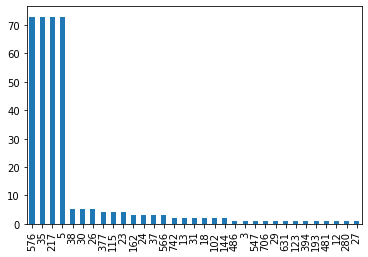

In [9]:
#Estimated number of agencies for each LOST measure
agencies_per_lost = measures_providers_joined['cdtfa_id'].value_counts()
agencies_per_lost.plot(kind='bar')

In [10]:
#add transit agency count estimate to measures df
measures_agency_count = measures.set_index('cdtfa_id')
measures_agency_count['transit_agency_count'] = agencies_per_lost

In [11]:
cdtfa = cat.cdtfa.read()
cdtfa = (cdtfa.astype({'Jurisdiction Id':str})
            .set_index('Jurisdiction Id'))

In [12]:
measures_cdtfa = (cdtfa[cdtfa['Calendar Year'] == 2020]
                   .join(measures_agency_count, how='inner')
                  )

In [13]:
measures_cdtfa['total_pct_transit'] = measures_cdtfa['total_pct_transit'] * 100

### Transit Agency Count, LOST Percent Funding Transit, and Q3 2020 LOST Reciepts by Measure: 

* Agency count currently includes all agencies within a LOST county, not neccesarily those funded by the LOST
* Agency-level funding formulas can be added manually as available to a version of these data

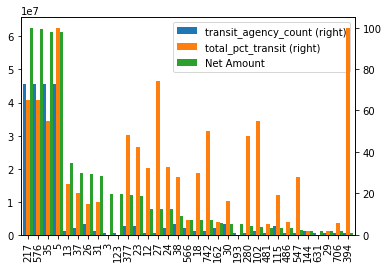

In [14]:
(measures_cdtfa[measures_cdtfa['Quarter'] == 3][['transit_agency_count', 'total_pct_transit', 'Net Amount']]
 .sort_values(by='Net Amount', ascending=False)
 .plot(kind='bar', secondary_y=['transit_agency_count','total_pct_transit'], width=1));

In [15]:
measures_cdtfa.loc['27']

,Calendar Year,Quarter,Acronym,Jurisdiction,Gross,Prior Advance,Administrative Cost,Net Amount,ballot_designation,county_fips,...,pct_transit_capital,pct_local_return,pct_hwy,pct_streets,pct_discretionary,year,amendable,change_feq,two_thirds_req,transit_agency_count
27,2020,3,SFTA,San Francisco County Transportatio,21550178.48,13563400.25,244560.0,7742218.23,Proposition K,6073,...,NaN,NaN,NaN,0.246,0.013,2004.0,True,NaN,NaN,1
27,2020,2,SFTA,San Francisco County Transportatio,21021696.34,17898728.17,244560.0,2878408.17,Proposition K,6073,...,NaN,NaN,NaN,0.246,0.013,2004.0,True,NaN,NaN,1
27,2020,1,SFTA,San Francisco County Transportatio,18403266.64,14492006.69,266280.0,3644979.95,Proposition K,6073,...,NaN,NaN,NaN,0.246,0.013,2004.0,True,NaN,NaN,1
